In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
from fastai.text import *

In [4]:
path = Path('../input')

In [5]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [6]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

In [8]:
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

In [9]:
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [10]:
train_df['question_text'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_text(x))
train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_numbers(x))
train_df['question_text'] = train_df['question_text'].apply(lambda x: replace_typical_misspell(x))

In [11]:
%%time
bs = 48
data_lm = (TextList.from_df(train_df, '.', cols='question_text')
           .split_by_rand_pct(0.1)
           .label_for_lm()           
           .databunch(path='.', bs=bs))

CPU times: user 24.9 s, sys: 11.5 s, total: 36.3 s
Wall time: 13min 36s


In [12]:
data_lm.show_batch()

idx,text
0,"for palestinians ? xxbos why does quora automatically ban conservative opinions when reported , but does not do the same for liberal views ? xxbos is it crazy if i wash or wipe my groceries off ? germs are everywhere . xxbos is there such a thing as dressing moderately , and if so , how is that different than dressing modestly ? xxbos is it just me or have"
1,do the preponderance of writers and speakers prefer utilize / utilized rather than the simpler and equally meaningful use / used ? xxbos xxunk is the eath going to end ? xxbos what is an satellite uplink in the ghost in the shell universe ? xxbos how would you defeat the at - te in star wars ? xxbos for all of you nobodies out there stop trying to xxunk
2,"the water ? xxbos how many people are familiar with the history of herbs , their medicinal as well as culinary uses ? xxbos is there a connection between the colors of lightning of various flash / reverse flash and speed force ? xxbos if i took pete , and xxunk him up till he weighed # # # lbs , and accelerated him to 0 . # # #"
3,"sharing water , love , language , religion , gender , sexual orientation and what not . xxbos why do i still miss my ptsd ex gf ? xxbos what is a priest in a video game ? xxbos does ravindrababu ravula sir conduct any online test for us after his hadoop course so that we can get a certificate ? xxbos what is the meaning of xxunk xxunk xxunk"
4,? xxbos why do you think democracy is considered the best form of government ? xxbos what are the tips for effective education startup ? xxbos have ' reds under the bed ' been replaced by ' journalists under the bed ' ? xxbos what is something or anything that is not related or can some how be tied to business ? xxbos what does psychology says if a girl


In [18]:
data_lm.save()

In [19]:
!ls

__notebook_source__.ipynb  data_save.pkl  models


In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


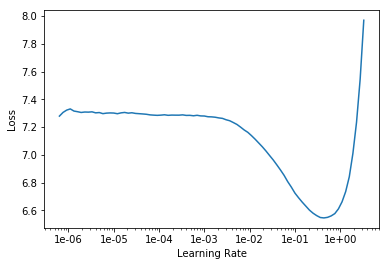

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.857892,4.680835,0.291387,17:07


In [20]:
learn.save('only_head')

In [21]:
learn.load('only_head');

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(3, slice(1e-4, 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.254464,4.154439,0.333192,19:15
1,4.012599,3.927451,0.350970,19:14
2,3.914022,3.864240,0.356435,19:14


In [24]:
learn.save('fine_tuned')

In [25]:
learn.load('fine_tuned');

In [28]:
TEXT = "why does quora automatically"
N_WORDS = 40
N_SENTENCES = 2

In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

why does quora automatically use a time machine when the data are not for the internet ? xxbos what is the best way for 2 dose to get a 3 . 5 gpa ? xxbos how many jews have come across a language of
why does quora automatically delete expression ? xxbos what are your views on the great wall in #### ???? xxbosxxbosxxbosxxbos howhowhowhow cancancancan iiii stopstopstopstop mymymymy fearfearfearfear fromfromfromfrom thinkingthinkingthinkingthinking aboutaboutaboutabout beingbeingbeingbeing noticednoticednoticednoticed bybybyby anananan atheistatheistatheistatheist ???? xxbosxxbosxxbosxxbos whatwhatwhatwhat isisisis thethethethe mostmostmostmost followedfollowedfollowedfollowed thingthingthingthing


In [30]:
learn.save_encoder('fine_tuned_enc')

In [32]:
test = TextList.from_df(test_df, '.', cols='question_text')

In [36]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province...,0
1,000032939017120e6e44,"do you have an adopted dog , how would you en...",0
2,0000412ca6e4628ce2cf,why does velocity affect time ? does velocity...,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0


In [ ]:
data_class = (TextList.from_df(train_df, '.', cols='question_text', vocab=data_lm.vocab)
              .split_by_rand_pct(0.1)
              .label_from_df('target')
              .add_test(test)
              .databunch(path='.', bs=bs))